In [127]:
import pandas as pd
import numpy as np
import datetime
import operator
import pickle
import keras, keras.backend as K
import math

from isoweek import Week
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt

from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils.layer_utils import layer_from_config
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer


In [157]:
%cd ~/dlcookbook/dlusecases/salesforecast/

/home/ubuntu/dlcookbook/dlusecases/salesforecast


# 1 Summary

This notebook creates a neural network, which forecasts sales date per store. The implementation can forecast the revanue sales with an error of 9% (mean absolute percentage error). The implementation achieves a RMSPE (Root Mean Square Percentage Error) of 11%. <br><br>The data are part from the kaggle competition <a href='https://www.kaggle.com/c/rossmann-store-sales'>Rossmann Store Sales</a>:<br>
<ul>
  <li>1115 stores</li>
  <li>2.5 years of data (daily)</li>
  <li>~1 million records</li>
</ul>
<br><br>The main feature is to use embeddings for all categorical variables. The network architecture for categorical variables is drafted as<br><br>
<img src='./src/structure.png'><br><br>

Visualization of predictions (orange):
<img src='./src/example.png'><br><br>


Resources:<br>
<ul>
  <li><a href='https://www.kaggle.com/c/rossmann-store-sales'>Kaggle Competition</a/></li>
  <li><a href='https://arxiv.org/pdf/1604.06737.pdf'>Guo/Berkhahns paper about the implemenation</a/></li>
  <li><a href='https://github.com/fastai/courses/blob/master/deeplearning2/rossman.ipynb'>Implementation by fast.ai</a/></li> 
</ul>


Keywords: Deep Learning, Time Series, Embeddings, Forecast, Sales Forecast

# 2 Data Loading

Defining the different table names and loading them

In [3]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']

In [4]:
tables = [pd.read_csv('./data/'+fname+'.csv', low_memory=False) for fname in table_names]

Table Definitions:<br>
train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.<br>
store: general info about the store including competition, etc.<br>
store_states: maps store to state it is in<br>
state_names: Maps state abbreviations to names<br>
googletrend: trend data for particular week/state<br>
weather: weather conditions for each state<br>
test: Same as training table, w/o sales and customers<br><br>
Assinging tables to single objects

In [5]:
train = tables[0]
store = tables[1]
store_states = tables[2]
state_names = tables[3]
googletrend = tables[4]
weather = tables[5]
test = tables[6]

# 3 Data Cleaning & Featue Engineering

Transforming Holiday as a booleanflag

In [6]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

In [7]:
def join_df(left, right, left_on, right_on=None):
    # Joins automatically two dataframes
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

def add_datepart(df):
    # Extracts the Year, Month, Week and Day from a timestamp
    df.Date = pd.to_datetime(df.Date)
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Week"] = df.Date.dt.week
    df["Day"] = df.Date.dt.day

Transforming the data (mainly the date) and join all dataframes to one object

In [8]:
weather = join_df(weather, state_names, "file", "StateName")

In [9]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [10]:
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)
add_datepart(test)

In [11]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [12]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [13]:
joined = join_df(train, store, "Store")
len(joined[joined.StoreType.isnull()])

0

In [14]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()])

0

In [15]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()])

0

In [16]:
joined = join_df(joined, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()])

0

In [17]:
joined_test = test.merge(store, how='left', left_on='Store', right_index=True)
len(joined_test[joined_test.StoreType.isnull()])

48

Replacing NA Values

In [18]:
joined.CompetitionOpenSinceYear = joined.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
joined.CompetitionOpenSinceMonth = joined.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
joined.Promo2SinceYear = joined.Promo2SinceYear.fillna(1900).astype(np.int32)
joined.Promo2SinceWeek = joined.Promo2SinceWeek.fillna(1).astype(np.int32)

In [19]:
joined["CompetitionOpenSince"] = pd.to_datetime(joined.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1).astype(pd.datetime))
joined["CompetitionDaysOpen"] = joined.Date.subtract(joined["CompetitionOpenSince"]).dt.days

In [20]:
joined.loc[joined.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined.loc[joined.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [21]:
joined["CompetitionMonthsOpen"] = joined["CompetitionDaysOpen"]//30
joined.loc[joined.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24

In [22]:
joined["Promo2Since"] = pd.to_datetime(joined.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
joined["Promo2Days"] = joined.Date.subtract(joined["Promo2Since"]).dt.days

In [23]:
joined.loc[joined.Promo2Days<0, "Promo2Days"] = 0
joined.loc[joined.Promo2SinceYear<1990, "Promo2Days"] = 0

In [24]:
joined["Promo2Weeks"] = joined["Promo2Days"]//7
joined.loc[joined.Promo2Weeks<0, "Promo2Weeks"] = 0
joined.loc[joined.Promo2Weeks>25, "Promo2Weeks"] = 25

## Durations

Adding informatino when was last / will be next Promo, Holiday, SchoolHoliday per Store

In [28]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [29]:
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.Store != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if (row[self.fld]): self.last = row.Date
        return row.Date-self.last
    
def add_elapsed(fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1) 

In [30]:
df = train[columns]

In [31]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [32]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [33]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [34]:
df = df.set_index("Date")

In [35]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [36]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(pd.Timedelta(0)).dt.days

In [37]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [38]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [39]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [40]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [41]:
df.reset_index(inplace=True)

In [42]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [43]:
df.drop(columns,1,inplace=True)

In [44]:
df.to_csv('df.csv')

In [45]:
joined = join_df(joined, df, ['Store', 'Date'])

In [47]:
joined.to_csv('joined2.csv')

In [48]:
joined = pd.read_csv('joined2.csv')

In [49]:
joined["Date"] = pd.to_datetime(joined.Date)

## Create Features

Selecting categorical variables<br>
Selecting numerical variables

In [50]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [51]:
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

Replacing null values

In [52]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""

In [53]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [54]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [55]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


16

In [56]:
pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))

# 4 Model

## Training/Validation Set

In [57]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

Datapoints without sales (=0) were removed in the scoring

In [58]:
joined_sales = joined[joined.Sales!=0]

In [59]:
joined_sales = joined_sales.set_index("Date")

In [60]:
joined_sales = joined_sales.sort_index()

In [61]:
train_ratio = 0.9
train_size = int(len(joined_sales) * train_ratio)

Splitting data into train/evaluation set based on timeline (time series analysis)

In [62]:
joined_valid = joined_sales[train_size:]
joined_train = joined_sales[:train_size]
len(joined_valid), len(joined_train)

(84434, 759904)

In [63]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Data Preparation

In [64]:
y_train_orig = joined_train.Sales
y_valid_orig = joined_valid.Sales

In [65]:
max_log_y = np.max(np.log(joined_sales.Sales))
y_train = np.log(y_train_orig)/max_log_y
y_valid = np.log(y_valid_orig)/max_log_y

## Create Model

In [76]:
def rmspe(y_pred, targ = y_valid_orig):
    pct_var = (targ - y_pred)/targ
    return math.sqrt(np.square(pct_var).mean())

def mpe(y_pred, targ = y_valid_orig):
    pct_var = np.abs((targ - y_pred))/targ
    return (pct_var.mean())

def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)

def normalize_inv(preds):
    return preds * ystd + ymean

def split_cols(arr): 
    return np.hsplit(arr,arr.shape[1])

def cat_map_info(feat): 
    return feat[0], len(feat[1].classes_)

def emb_init(shape, name=None): 
    return initializations.uniform(shape, scale=2/(shape[1]+1), name=name)

def get_emb(feat):
    name, c = cat_map_info(feat)
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1, init=emb_init)(inp))
    return inp,u

In [67]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

In [68]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)

In [69]:
embs = [get_emb(feat) for feat in cat_map_fit.features]
x = merge([emb for inp,emb in embs] + [contin_out], mode='concat')

x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', init='uniform')(x)
x = Dense(500, activation='relu', init='uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

In [70]:
model = Model([inp for inp,emb in embs] + [contin_inp], x)
model.compile('adam', 'mean_absolute_error')

In [71]:
model.fit(map_train, y_train, batch_size=128, nb_epoch=20, verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],  validation_data=(map_valid, y_valid))

In [72]:
preds = np.squeeze(model.predict(map_valid, 1024))

# 5 Conclusion

In [151]:
def pltResult(vis_true, vis_predict, filename):
    plt.figure(figsize=(20, 8))
    plt.plot(vis_true.Date, vis_true.Sales, vis_predict.Date, vis_predict.Sales)
    plt.savefig(filename)
    plt.show()

In [130]:
rmspe(log_max_inv(preds))

0.12570395286244773

In [131]:
mpe(log_max_inv(preds))

0.09064219892024994

In [132]:
vis_train = joined_train.reset_index()
vis_train = vis_train[['Date', 'Store', 'Sales']]
vis_valid = joined_valid.reset_index()
vis_valid = vis_valid[['Date', 'Store', 'Sales']]
vis_combind = vis_train.append(vis_valid)

In [133]:
vis_combind_full = vis_combind[['Date', 'Sales']].groupby(['Date']).sum()
vis_combind_full = vis_combind_full.reset_index()

In [134]:
vis_predict = vis_valid
vis_predict.Sales = log_max_inv(preds)

In [139]:
vis_predict_full = vis_predict[['Date', 'Sales']].groupby(['Date']).sum()
vis_predict_full = vis_predict_full.reset_index()

Visualize Full Time Frame

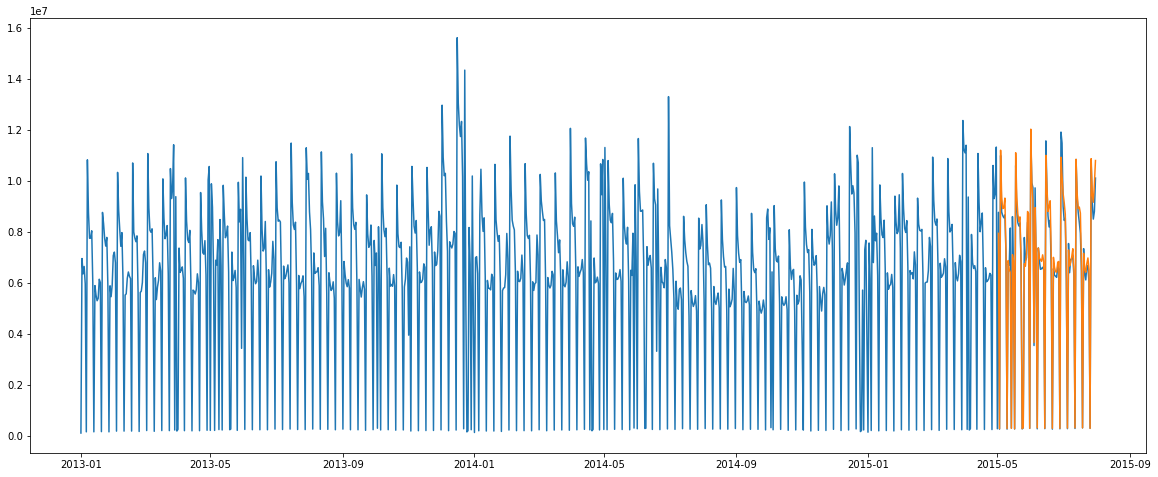

In [152]:
pltResult(vis_combind_full, vis_predict_full, './src/vis_fulltime.png')

Visualize 2015

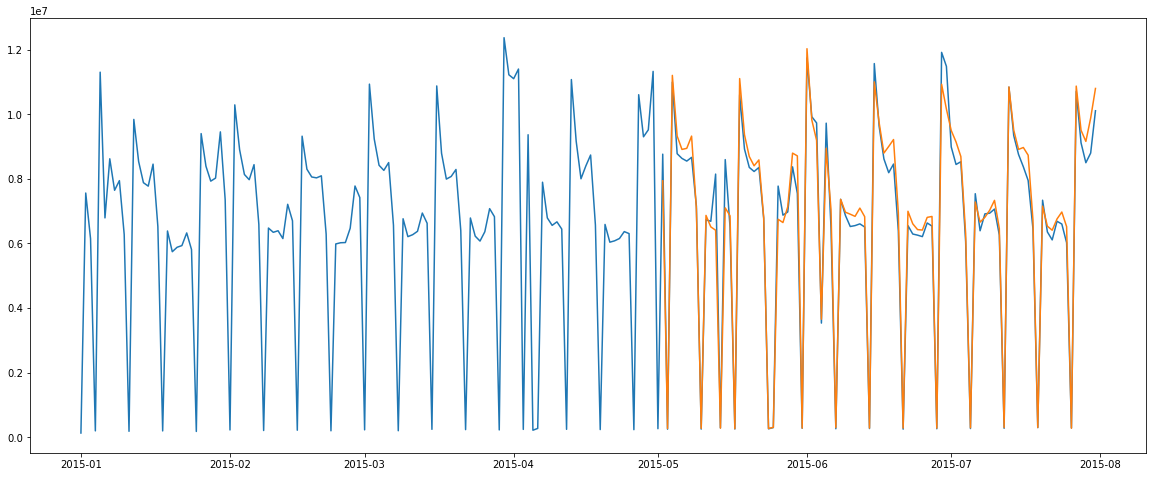

In [153]:
pltResult(vis_combind_full[vis_combind_full.Date>='01-01-2015'], vis_predict_full, './src/vis_2015.png')

Visualize a specific store

In [144]:
store_id = 1097

In [145]:
vis_combind_store = vis_combind[vis_combind.Store==store_id]

vis_combind_store = vis_combind_store[['Date', 'Sales']].groupby(['Date']).sum()
vis_combind_store = vis_combind_store.reset_index()

In [146]:
vis_predict_store = vis_predict[vis_predict.Store==store_id]

vis_predict_store = vis_predict_store[['Date', 'Sales']].groupby(['Date']).sum()
vis_predict_store = vis_predict_store.reset_index()

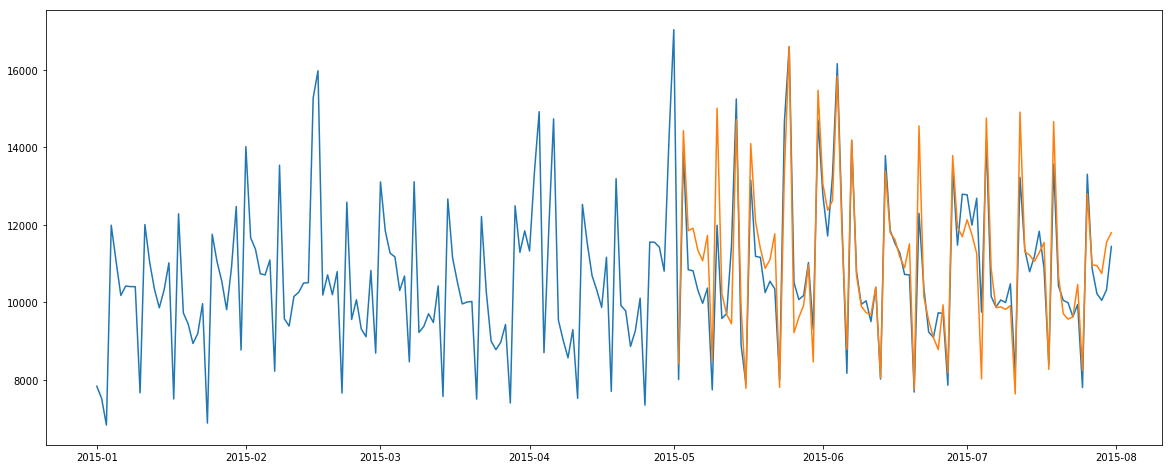

In [154]:
pltResult(vis_combind_store[vis_combind_store.Date>='01-01-2015'], vis_predict_store, './src/vis_store_2015.png')